In [116]:
import pandas as pd
import MultiContagion as mc
import igraph
import random
import numpy as np
from matplotlib import pylab as plt
import scipy.stats
import copy
#import powerlaw
%matplotlib inline

In [117]:
#year for which to compute the contagion model.
year = 2009

In [118]:
#import the aggregate adjacency matrix
aggregate_am = np.genfromtxt ('csv_files/AM_all_nodes_aggregateNorm'+str(year)+'.csv', delimiter=",")
df_names = pd.read_csv('csv_files/all_country_name.csv', header=None)
names = list(df_names[0])
Aggregate_g = igraph.Graph.Weighted_Adjacency(list(aggregate_am))
Aggregate_g.vs["name"] = copy.deepcopy(names)

In [119]:
#Remove isolated nodes will also cause bug
#to_delete_ids = [v.index for v in Aggregate_g.vs.select(_degree=0)]
#Aggregate_g.delete_vertices(to_delete_ids)

In [120]:
#len(Aggregate_g.vs["name"])

In [121]:
def Percolation(G, threshold= 0.5 ,chosen_one = -1, count_break = 300):
    '''Percolation model for a monoplex. A node becomes infected if a fraction of its neighbours is infected.
    Starts with random node, unless specified otherwise.'''
    damp = threshold #(weighted)fraction  of neighbours that must be infected, for node to become infected.
    AM_weight = G.get_adjacency(attribute="weight")
    in_strength_weight = G.strength(weights=G.es["weight"], mode = "IN")
    n_countries = len(AM_weight[0])
    susceptible = [i for i in range(n_countries)] #initiliaze with all nodes susceptible
    
    #set seed node, if none specified then it is random
    if chosen_one == -1: 
        chosen_one = random.choice(susceptible)
    infected = [[chosen_one]]    
    susceptible.remove(chosen_one)

    count = 0
    for t in range(n_countries): #maximun number of steps simulation can have
        infected.append([])
        for i in range(n_countries):
            weights_infected_neigh = 0
            if i in infected[count]: #if node is infected it will keep being infected.
                infected[count + 1].append(i)
                pass
            else: #if it is not infected we must check on its neighbors
                in_neigh_list = G.vs[i].neighbors(mode = "IN")
                if in_strength_weight[i] == 0:
                    #print i
                    pass
                else:
                    for j in range(len(in_neigh_list)):
                        graph_index = in_neigh_list[j].index   
                 
                        if graph_index in infected[count]:
                            weights_infected_neigh +=AM_weight[graph_index][i]
                        
                    #compute fraction of weights coming from neighbors which are infected
                    
                    frac_weight_inf_neigh = float(weights_infected_neigh)/in_strength_weight[i]
    
                
                    if frac_weight_inf_neigh > threshold: #if the fraction of infected nodes is above threshold become infected
                        infected[count + 1].append(i)
                        susceptible.remove(i)
                    
        count += 1            
        
        if len(infected[t]) == len(infected[t + 1]): #end when there is no update on infected nodes
            break
        if count > count_break:
            print "warning"
            break
                
    return infected

In [122]:
#simple run for the aggregate monoplex network.
#perco = Percolation(Aggregate_g, threshold= 0.1, chosen_one= 220) #we can test the results
#print "T = ", 0.1, "time = ", len(perco), "size =", len(perco[-1])

In [123]:
def countries_starting_num(countries_name_starting, g):
    '''Function takes a list of the strings of countries and returns a list of index of those countries in graph g'''
    c_list = []
    for c in countries_name_starting:
        c_list.append(g.vs["name"].index(c))
    return c_list

In [124]:
#The countries we want as seed nodes
countries_name_starting = ["United States", "United Kingdom", "Netherlands", "Luxembourg", "China P.R.: Hong Kong" ]
countries_starting = countries_starting_num(countries_name_starting, Aggregate_g)

In [125]:
#A simple test of the percolation mode
#for c in countries_starting:
#   print Aggregate_g.vs["name"][c]
#   for T in threshold_list:
#        perco = Percolation(Aggregate_g, threshold= T, chosen_one= c)
#        print "T = ", T, "time = ", len(perco), "size =", len(perco[-1])

### Multilayer

In [126]:
#Import the adjacency matrix and make graphs of all the layers.
cdis_equity_am = np.genfromtxt ('csv_files/AM_all_nodesNormCDIS-equity'+str(year)+'.csv', delimiter=",")
cdis_equity_g = igraph.Graph.Weighted_Adjacency(list(cdis_equity_am))
cdis_equity_g.vs["name"] = copy.deepcopy(names)

cdis_debt_am = np.genfromtxt ('csv_files/AM_all_nodesNormCDIS-debt'+str(year)+'.csv', delimiter=",")
cdis_debt_g = igraph.Graph.Weighted_Adjacency(list(cdis_debt_am))
cdis_debt_g.vs["name"] = copy.deepcopy(names)

cpis_equity_am = np.genfromtxt ('csv_files/AM_all_nodesNormCPIS-equity'+str(year)+'.csv', delimiter=",")
cpis_equity_g = igraph.Graph.Weighted_Adjacency(list(cpis_equity_am))
cpis_equity_g.vs["name"] = copy.deepcopy(names)

cpis_debt_am = np.genfromtxt ('csv_files/AM_all_nodesNormCPIS-debt'+str(year)+'.csv', delimiter=",")
cpis_debt_g = igraph.Graph.Weighted_Adjacency(list(cpis_debt_am))
cpis_debt_g.vs["name"] = copy.deepcopy(names)

bis_am = np.genfromtxt ('csv_files/AM_all_nodesNormBIS'+str(year)+'.csv', delimiter=",")
bis_g = igraph.Graph.Weighted_Adjacency(list(bis_am))
bis_g.vs["name"] = copy.deepcopy(names)

In [127]:
def intersect(*d):
    sets = iter(map(set, d))
    result = sets.next()
    for s in sets:
        result = result.intersection(s)
    return result

In [128]:
def make_G_no_global_isolated(G_list):
    '''will remove globally isolated node from all graphs in Glist. Warning it alterates global graphs'''
    list_all_isolated = []
    for g in G_list:
        list_all_isolated.append([v.index for v in g.vs.select(_degree=0)])
    
    to_delete_ids = list(set(list_all_isolated[0]).intersection(*list_all_isolated))
    for g in G_list:
        g.delete_vertices(to_delete_ids)
        

In [129]:
def multi_percolation_Tlist(G_list, thresholdlist, chosen_one = -1, count_break = 1e3):
    '''Threshold model for multilayer. Takes a list of graphs and a threshold, and runs a
    contagion mechanism on the multiplex networkuses the fraction of weighted degree which comes from infected neighbors. If a node is infected in one layer, same node
    is infected. Seeds node is random, unless specified otherwise.'''
    #make_G_no_global_isolated(G_list) #Remove isolated nodes - triggers bug
    
    AM_weight = [G.get_adjacency(attribute="weight") for G in G_list]
    in_strength_weight = [G.strength(weights=G.es["weight"], mode = "IN") for G in G_list]
    
    
    n_layers = len(G_list)
    max_countries = max([len(AM_weight[l][0]) for l in range(n_layers)])
    
    susceptible = [i for i in range(max_countries)]
    if chosen_one == -1:
        chosen_one = random.choice(susceptible)
    
    susceptible.remove(chosen_one)
    infected = [[[chosen_one]] for i in range(n_layers)] #Assume node in contagion is same for all layers  

    count = 0
    for t in range(count_break): #maximun number of steps simulation can have, above number of countries implies bug.
        
        for l in range(n_layers):

            infected[l].append([])
            n_countries = len(AM_weight[l][0])
            for i in range(n_countries):
                weights_infected_neigh = 0
                already_infected = False
                
                if in_strength_weight[l][i] == 0: #avoid division by 0, there are node with in_str = 0
                    pass
                else:
                    for inf in infected:
                        if i in inf[count]:#if node is infected in at least one layer it will 
                                        #be infected in next time step
                            #print infected[l][count + 1]
                            if i not in infected[l][count + 1]:
                                infected[l][count + 1].append(i)
                                #print infected[l][count + 1]

                            try: #May have been removed already by another layer
                                susceptible.remove(i)
                            except:
                                pass
           
                    else: #if it is not infected becoming infected depends on its neighbors
                        in_neigh_list = G_list[l].vs[i].neighbors(mode = "IN")
                        for j in range(len(in_neigh_list)):
                            graph_index = in_neigh_list[j].index   
                 
                            if graph_index in infected[l][count]:
                                weights_infected_neigh +=AM_weight[l][graph_index][i]
                
                        frac_weight_inf_neigh = float(weights_infected_neigh)/in_strength_weight[l][i]
                    
                        if frac_weight_inf_neigh > thresholdlist[l]:
                            if i not in infected[l][count + 1]:
                                infected[l][count + 1].append(i)
                            #susceptible.remove(i)
                            
               
            
        count += 1            
        boul = False
        for k in range(n_layers):
            if t != 0:
                if len(infected[k][t - 1]) == len(infected[k][t + 1]): #break when there is no update
                    boul = True
                else:
                    boul = False
                    break
        if boul:
            break
        
        if count == count_break - 5:
            print "warning"
            break
                
    return infected, susceptible

### Defining thesholds


In [130]:
def make_thresholds_constant(ti = 0.1, tf = 0.8 , steps = 5, layers = 5):
    '''returns list of constantly changin thresholds'''
    T = []
    for t in np.linspace(ti, tf, steps):
        T.append([round(t, 2), [round(t, 2) for i in range(layers)]])
    return T

In [131]:
def make_thresholds_var_av(ti = 0.2, tf = 0.8,  layers = 5):
    '''make different thresholds for different layers'''
    mean = np.mean([ti, tf])
    T = []
    T.append([round(mean, 2),  [ round(i,2) for i in np.linspace(ti, tf, layers)] ])
    return T

### Simulation for homogenous layers, making plots

United States


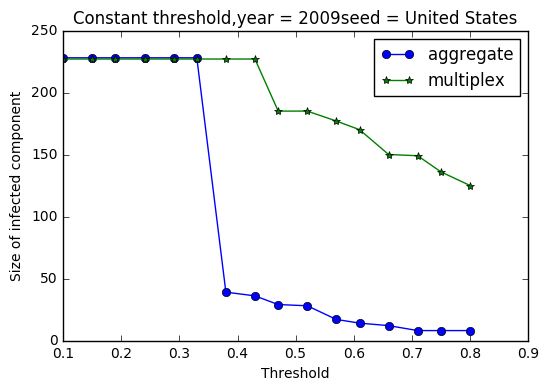

United Kingdom


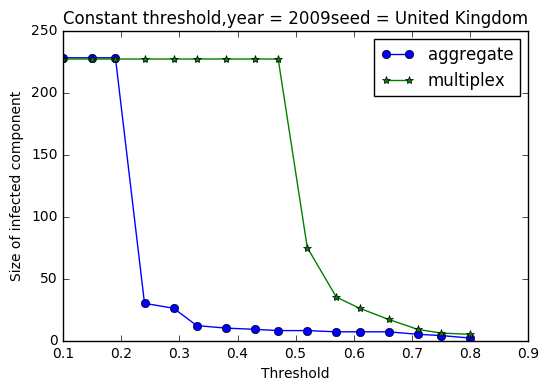

Netherlands


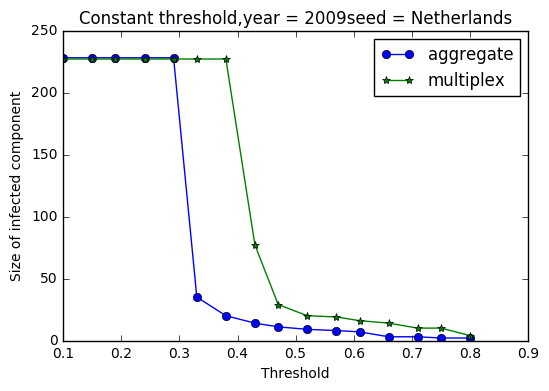

Luxembourg


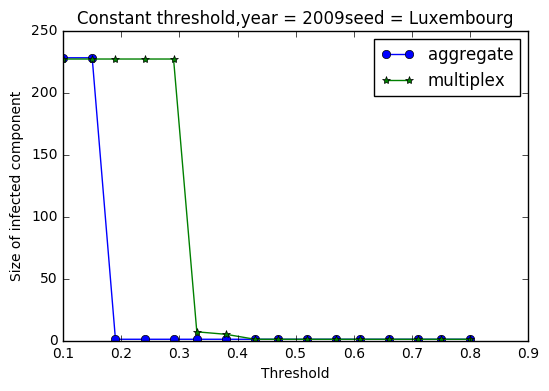

China P.R.: Hong Kong


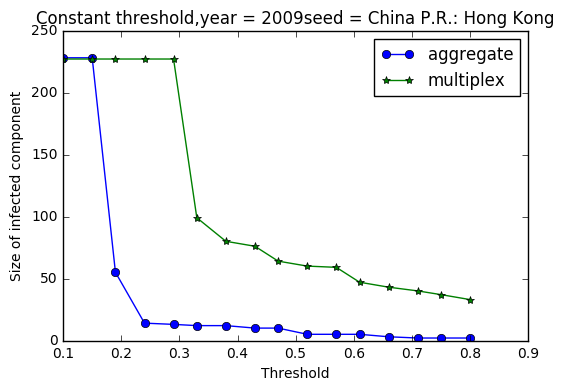

In [132]:
Thresholds = make_thresholds_constant(tf = 0.8,steps=16) #+ make_thresholds_var_av() + make_thresholds_var_av(ti = 0.4, tf = 0.6)
S_agg = []
S_multi = []
name1 = []
T_1 = []
count = 0
Aggregate_g.vs["name"][43] = "China  P.R.: Hong Kong"

affected =[]
count1 = -1
for c in countries_starting:    #start percolation with a given seed node.
    fig = plt.figure()
    ax = plt.subplot(111)
    print Aggregate_g.vs["name"][c] #All layers and aggregate have same nodes (isolated were not removed)
    name1.append(Aggregate_g.vs["name"][c])
    s_agg = []
    s_multi = []
    T_1 = []
    affected.append([])
    count1 += 1
    for T in Thresholds:
        perco = Percolation(Aggregate_g, threshold= T[0], chosen_one= c)
        s_agg.append(len(perco[-1]))
        percomulti = multi_percolation_Tlist([cdis_equity_g, cdis_debt_g, cdis_equity_g, cpis_debt_g, bis_g], T[1], chosen_one= c, count_break= 1000)[0]
        s_multi.append(len(percomulti[0][-1]))
        affected[count1].append(percomulti[0][-1])
        #for country_index in percomulti[0][-1]:
        #    print Aggregate_g.vs["name"][country_index]
        #print "\n"
        T_1.append(T[0])
    S_agg.append(s_agg)
    S_multi.append(s_multi)
    plt.plot(T_1, S_agg[count], "o-", label = "aggregate")
    plt.plot(T_1, S_multi[count], "*-", label = "multiplex")
    plt.title("Constant threshold,year = "+str(year)+  "seed = "+ name1[count] )
    plt.xlabel("Threshold")
    plt.ylabel("Size of infected component")
    box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.legend()
    plt.savefig("fig/ContagionConstantThreshold_"+name1[count1]+str(year)+".png")
    plt.show()
    count += 1

### Simulation for homogenous layers, making csv files

In [133]:
def multi_percolation_Tlist_tocsv(G_list, thresholdlist, chosen_one = -1, count_break = 1e3):
    '''Threshold model for multilayer, saves results into csv. Takes a list of graphs and a threshold, and runs a
    contagion mechanism on the multiplex networkuses the fraction of weighted degree which comes from infected neighbors. If a node is infected in one layer, same node
    is infected. Seeds node is random, unless specified otherwise.'''
    #make_G_no_global_isolated(G_list) #Remove isolated nodes - triggers bug, index problem.
    
    AM_weight = [G.get_adjacency(attribute="weight") for G in G_list]
    in_strength_weight = [G.strength(weights=G.es["weight"], mode = "IN") for G in G_list]
    
    
    n_layers = len(G_list)
    max_countries = max([len(AM_weight[l][0]) for l in range(n_layers)])
    
    susceptible = [i for i in range(max_countries)]
    if chosen_one == -1:
        chosen_one = random.choice(susceptible)
    
    seed_country_name = G_list[l].vs["name"][chosen_one]
    f = open("csv_files/ContagionHomoLayers_th"+str(thresholdlist[0])+seed_country_name+str(year)+".csv", "w")
    f.write("time step, layer, countries that become infected \n")
    
    susceptible.remove(chosen_one)
    infected = [[[chosen_one]] for i in range(n_layers)] #Assume node in contagion is same for all layers  

    count = 0
    for t in range(count_break): #maximun number of steps simulation can have, above number of countries implies bug.
        
        for l in range(n_layers):

            
            
            infected[l].append([])
            n_countries = len(AM_weight[l][0])
            for i in range(n_countries):
                weights_infected_neigh = 0
                already_infected = False
                
                if in_strength_weight[l][i] == 0: #avoid division by 0, there are nodes with in_str = 0
                    pass
                else:
                    for inf in infected:
                        if i in inf[count]:#if node is infected in at least one layer it will 
                                        #be infected in next time step
                            #print infected[l][count + 1]
                            if i not in infected[l][count + 1]:
                                infected[l][count + 1].append(i)
                                #print infected[l][count + 1]

                            try: #May have been removed already by another layer
                                susceptible.remove(i)
                            except:
                                pass
           
                    else: #if it is not infected becoming infected depends on its neighbors
                        in_neigh_list = G_list[l].vs[i].neighbors(mode = "IN")
                        for j in range(len(in_neigh_list)):
                            graph_index = in_neigh_list[j].index   
                 
                            if graph_index in infected[l][count]:
                                weights_infected_neigh +=AM_weight[l][graph_index][i] #sum weights of infected nodes
                
                        frac_weight_inf_neigh = float(weights_infected_neigh)/in_strength_weight[l][i] #fraction of infected weights
                    
                        if frac_weight_inf_neigh > thresholdlist[l]:
                            if i not in infected[l][count + 1]:
                                infected[l][count + 1].append(i)
                                f.write(str(t) +","+str(l) +","+ G_list[l].vs["name"][i]+ "\n")
                                #print l
                                #print  
                            #susceptible.remove(i)
                  
            
        count += 1            
        boul = False
        for k in range(n_layers):
            if t != 0:
                if len(infected[k][t - 1]) == len(infected[k][t + 1]): #break when there is no update
                    boul = True
                else:
                    boul = False
                    break
        if boul:
            break
        
        if count == count_break - 5:
            print "warning"
            break
    f.close()           
    return infected, susceptible

In [134]:
Thresholds = make_thresholds_constant(tf = 0.8,steps=16) 
for c in countries_starting:    #start percolation with a given seed node.
    print Aggregate_g.vs["name"][c] #All layers and aggregate have same nodes (isolated were not removed)
    name1.append(Aggregate_g.vs["name"][c])
    s_agg = []
    s_multi = []
    T_1 = []
    affected.append([])
    count1 += 1
    for T in Thresholds:
        perco = Percolation(Aggregate_g, threshold= T[0], chosen_one= c)
        s_agg.append(len(perco[-1]))
        percomulti = multi_percolation_Tlist_tocsv([cdis_equity_g, cdis_debt_g, cdis_equity_g, cpis_debt_g, bis_g], T[1], chosen_one= c, count_break= 1000)[0]

United States
United Kingdom
Netherlands
Luxembourg
China P.R.: Hong Kong
